# Calibration

In this notebook, I investigate if the win probabilities are calibrated. That is, when we say there is a 60% chance the red alliance wins, does the red alliance win 60% of the time? Long story short, the Elo model is very well calibrated (as a result of its computation), and the OPR and Mix models are fairly well calibrated. I tested calibration post-processing steps but these did not affect MSE significantly. I also investigated using a different ratio of Elo and OPR for the Mix model, but the optimal parameter changes year to year. In conclusion, no changes to the algorithm, yet.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error

In [2]:
matches = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/matches.csv")

In [3]:
matches.head()

,id,year,event_id,event,key,comp_level,set_number,match_number,red,red_elo_sum,...,blue_teleop_1,blue_teleop_2,blue_1,blue_2,blue_teleop,blue_endgame,blue_no_fouls,blue_fouls,blue_rp_1,blue_rp_2
0,1,2002,1,2002ca,2002ca_f1m1,f,1,1,"64,60",3150.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2002,1,2002ca,2002ca_f1m2,f,1,2,"64,60",3182.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2002,1,2002ca,2002ca_qf1m1,qf,1,1,"64,60",3073.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2002,1,2002ca,2002ca_qf1m2,qf,1,2,"64,60",3091.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2002,1,2002ca,2002ca_qf2m1,qf,2,1,"962,599",3025.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dataset = matches[matches.year == 2019]

actual = dataset.winner.apply(lambda x: 1 if x == "red" else 0)
predicted_elo = dataset.elo_win_prob
predicted_opr = dataset.opr_win_prob
predicted_mix = dataset.mix_win_prob

n_bins = 10
elo_calibration = calibration_curve(actual, predicted_elo, n_bins = n_bins)
opr_calibration = calibration_curve(actual, predicted_opr, n_bins = n_bins)
mix_calibration = calibration_curve(actual, predicted_mix, n_bins = n_bins)

C:\Users\Abhijit\AppData\Local\Temp/ipykernel_22428/441849.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


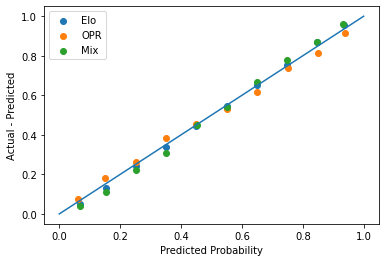

In [5]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1])
ax.scatter(elo_calibration[1], elo_calibration[0], label="Elo")
ax.scatter(opr_calibration[1], opr_calibration[0], label="OPR")
ax.scatter(mix_calibration[1], mix_calibration[0], label="Mix")
ax.set_xlabel("Predicted Probability")
ax.set_ylabel("Actual - Predicted")
ax.legend()

fig.show()

Elo	 0.18805724779628422
OPR	 0.19140628031640108
Mix	 0.18279952600380353
Best	 0.1826984082805531 0.56


C:\Users\Abhijit\AppData\Local\Temp/ipykernel_22428/647290946.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


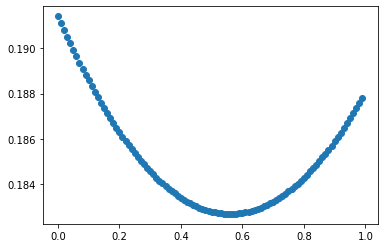

In [6]:
x = []
y = []

min_mse, best_elo_rate = 1, -1

for i in range(100):
    elo_rate = i / 100
    x.append(elo_rate)
    predicted = elo_rate * predicted_elo + (1 - elo_rate) * predicted_opr
    mse = mean_squared_error(actual, predicted)
    if mse < min_mse:
        min_mse, best_elo_rate = mse, elo_rate
    y.append(mse)
    
fig, ax = plt.subplots()
ax.scatter(x, y)
fig.show()

print("Elo\t", mean_squared_error(actual, predicted_elo))
print("OPR\t", mean_squared_error(actual, predicted_opr))
print("Mix\t", mean_squared_error(actual, predicted_mix))
print("Best\t", min_mse, best_elo_rate)